In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [8]:
# 1.ADIM: VERİ SETİ SECİMİ : Airline_Passenger_Satisfaction

In [9]:
#veri setini yükleme
df = pd.read_csv("/content/train.csv")

In [10]:
#veri setine kısa bir bakış ve bilgi alma
df.head()
df.info()

#veri setine genel bir bakış
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())


check_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [11]:
# 2.ADIM: İSTATİSTİKSEL ÖZET

In [12]:
# istatiklerle veri setimiz

sayisal_df = df.select_dtypes(include=["float64", "int64"])

# Temel istatistikleri getir
temel_istatistikler = sayisal_df.describe().T  # .T satır-sütun çevirir, okunabilirlik için

# Medyan sütunu da ekle
temel_istatistikler["medyan"] = sayisal_df.median()

# IQR (Q3 - Q1) ekle
temel_istatistikler["IQR"] = temel_istatistikler["75%"] - temel_istatistikler["25%"]

# Raporu göster
print(temel_istatistikler)

                                       count      mean       std    min       25%       50%       75%        max    medyan       IQR
Unnamed: 0                        103904.000 51951.500 29994.646  0.000 25975.750 51951.500 77927.250 103903.000 51951.500 51951.500
id                                103904.000 64924.211 37463.812  1.000 32533.750 64856.500 97368.250 129880.000 64856.500 64834.500
Age                               103904.000    39.380    15.115  7.000    27.000    40.000    51.000     85.000    40.000    24.000
Flight Distance                   103904.000  1189.448   997.147 31.000   414.000   843.000  1743.000   4983.000   843.000  1329.000
Inflight wifi service             103904.000     2.730     1.328  0.000     2.000     3.000     4.000      5.000     3.000     2.000
Departure/Arrival time convenient 103904.000     3.060     1.525  0.000     2.000     3.000     4.000      5.000     3.000     2.000
Ease of Online booking            103904.000     2.757     1.399  0.0

In [13]:
# 3.ADIM: EKSİK DEĞER ANALİZİ

                          n_miss  ratio
Arrival Delay in Minutes     310  0.300


,0
Unnamed: 0,0
id,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Inflight wifi service,0
Departure/Arrival time convenient,0


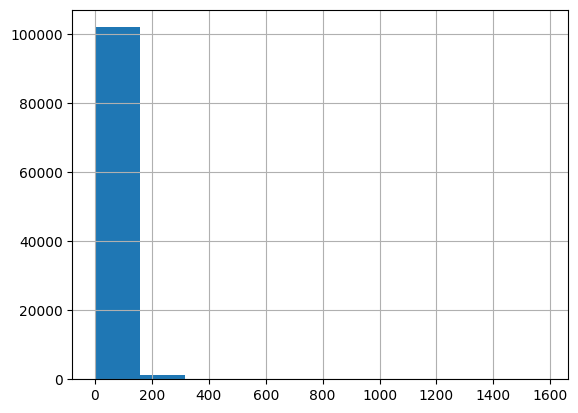

In [14]:
#eksik değer sayımız
df.isnull().sum()
#eksik değer detay
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

#eksik değerleri olan sutunumuzun veri setindeki durumu
df["Arrival Delay in Minutes"].hist()

#medyan ile doldurma
df["Arrival Delay in Minutes"].fillna(df["Arrival Delay in Minutes"].median(), inplace=True)

#eksik deger ikinci kontrol
df.isnull().sum()

In [15]:
# 4.ADIM: AYKIRI DEGER(OUTLİER) ANALİZİ

                                   aykiri_sayisi
Departure Delay in Minutes                 14529
Arrival Delay in Minutes                   13954
Checkin service                            12891
Flight Distance                             2291
Age                                            0
id                                             0
Unnamed: 0                                     0
Inflight wifi service                          0
Food and drink                                 0
Departure/Arrival time convenient              0
Ease of Online booking                         0
Gate location                                  0
Inflight entertainment                         0
Seat comfort                                   0
Online boarding                                0
On-board service                               0
Baggage handling                               0
Leg room service                               0
Cleanliness                                    0
Inflight service    

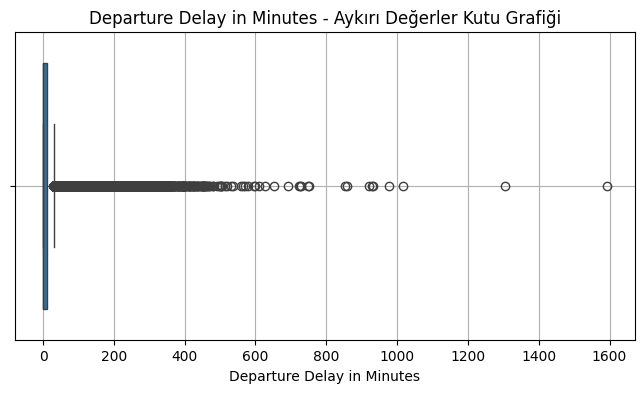

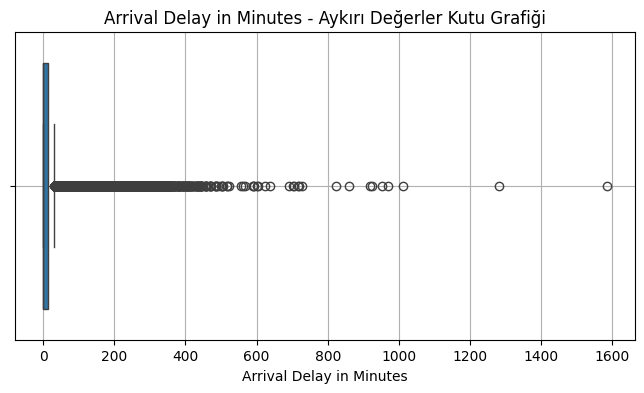

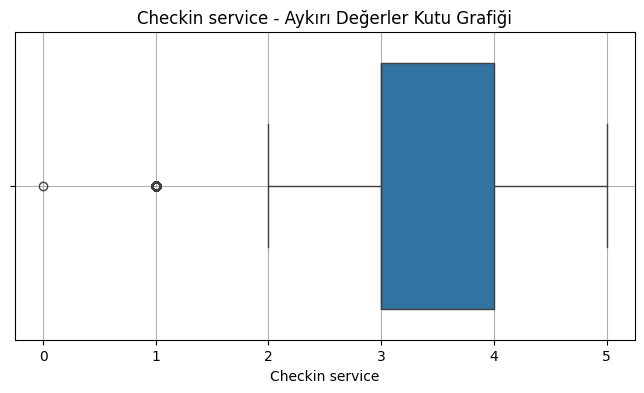

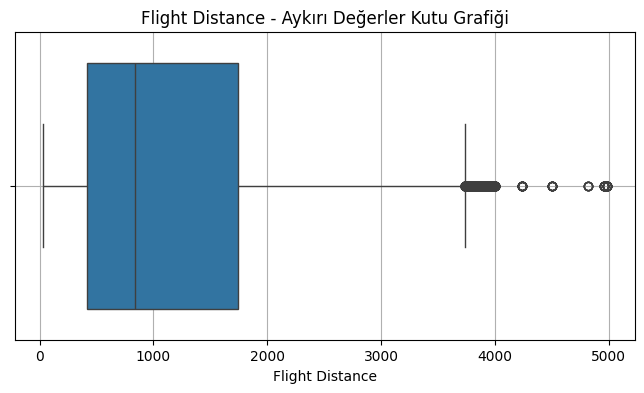

In [16]:
def aykiri_degerleri_bul_iqr(veri, grafik_goster=False):
    aykiri_ozet = {}

    for sutun in veri.select_dtypes(include=['float64', 'int64']).columns:
        q1 = veri[sutun].quantile(0.25)
        q3 = veri[sutun].quantile(0.75)
        iqr = q3 - q1
        alt_sinir = q1 - 1.5 * iqr
        ust_sinir = q3 + 1.5 * iqr

        aykirilar = veri[(veri[sutun] < alt_sinir) | (veri[sutun] > ust_sinir)]
        aykiri_ozet[sutun] = aykirilar.shape[0]

        if grafik_goster:
            import seaborn as sns
            import matplotlib.pyplot as plt
            sns.boxplot(x=veri[sutun])
            plt.title(f"{sutun} - Kutu Grafiği (Boxplot)")
            plt.show()

    return pd.DataFrame.from_dict(aykiri_ozet, orient='index', columns=["aykiri_sayisi"]).sort_values(
        by="aykiri_sayisi", ascending=False)

aykiri_rapor = aykiri_degerleri_bul_iqr(df, grafik_goster=False)
print(aykiri_rapor)

# Aykırı değer içeren sütunlar
aykiri_sutunlar = [
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
    "Checkin service",
    "Flight Distance"
]

# Her sütun için ayrı kutu grafiği çiz
for sutun in aykiri_sutunlar:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[sutun])
    plt.title(f"{sutun} - Aykırı Değerler Kutu Grafiği")
    plt.xlabel(sutun)
    plt.grid(True)
    plt.show()

In [17]:
# 5.ADIM: GORSELLESTİRME

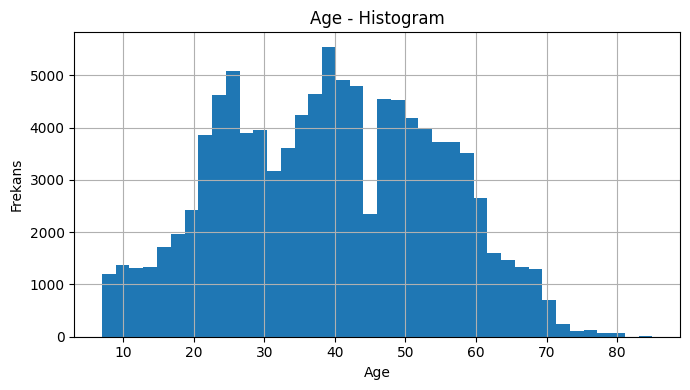

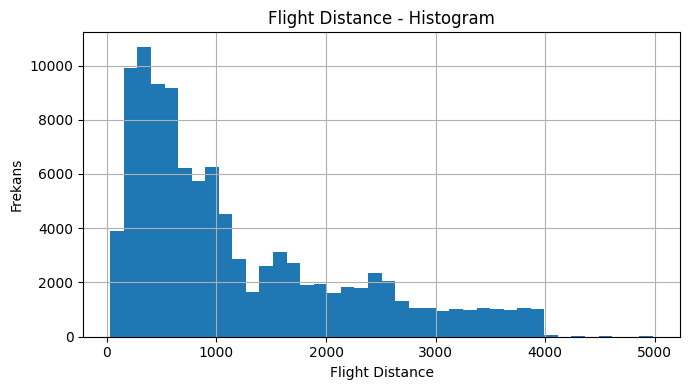

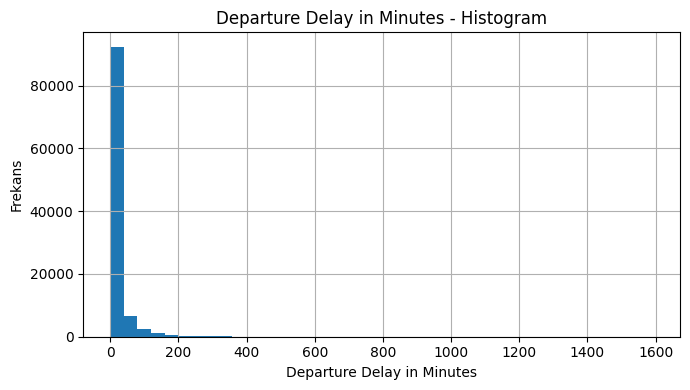

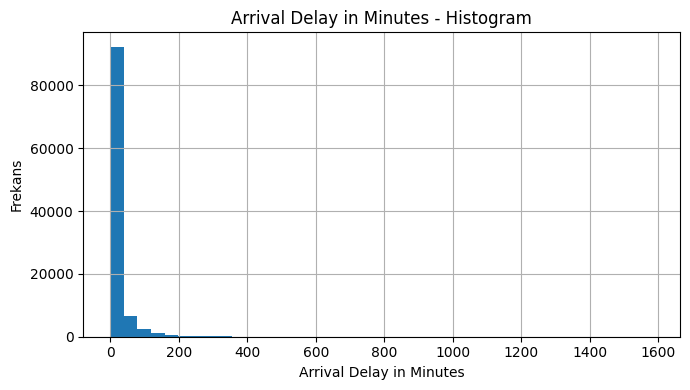

Kategorik değişkenler:
['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction']


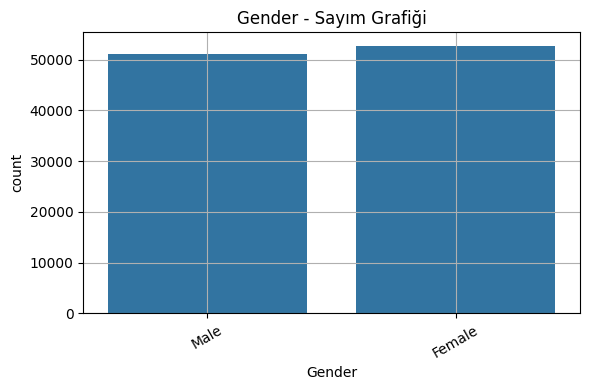

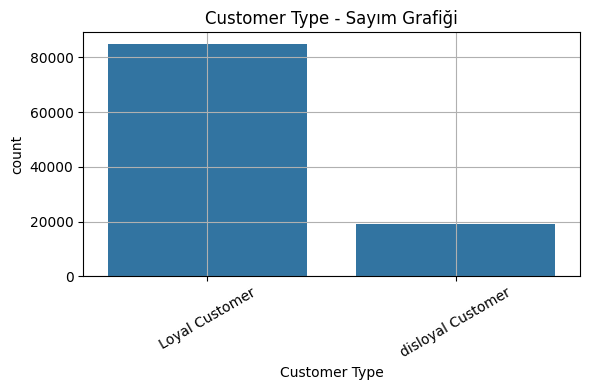

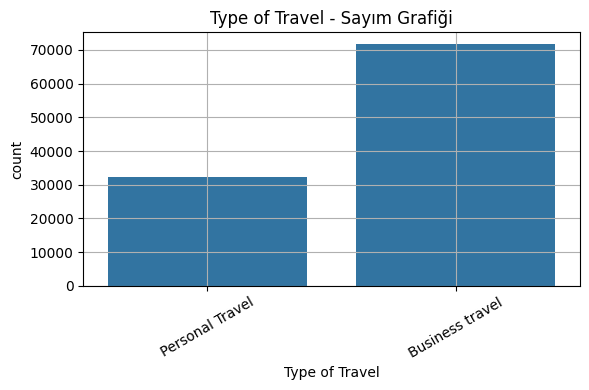

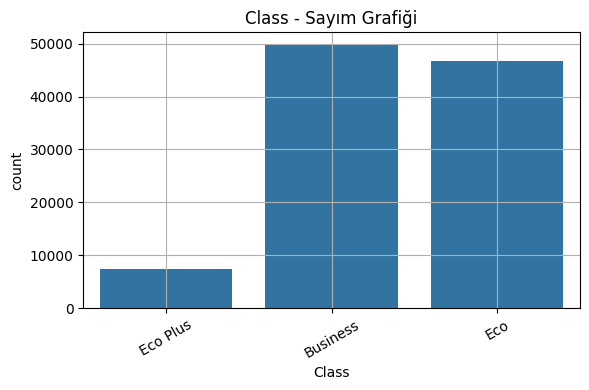

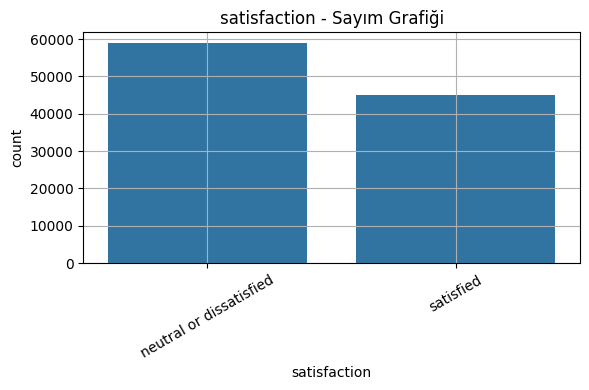

In [18]:
# Sayısal degiskenlerin görsellestirilmesi

sayisal_sutunlar = [
    "Age", "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes"
]

for sutun in sayisal_sutunlar:
    plt.figure(figsize=(7, 4))
    df[sutun].hist(bins=40)
    plt.title(f"{sutun} - Histogram")
    plt.xlabel(sutun)
    plt.ylabel("Frekans")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Kategorik degiskenlerin gorsellestirilmesi

kategorik_sutunlar = []

for sutun in df.columns:
    if df[sutun].dtype == "O":
        kategorik_sutunlar.append(sutun)
    elif df[sutun].nunique() < 10:
        kategorik_sutunlar.append(sutun)

print("Kategorik değişkenler:")
print(kategorik_sutunlar)

kategorik_sutunlarr = ["Gender", "Customer Type", "Type of Travel", "Class", "satisfaction"]

for sutun in kategorik_sutunlarr:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[sutun])
    plt.title(f"{sutun} - Sayım Grafiği")
    plt.xticks(rotation=30)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [1]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
